# Size of images  at USDF 

In [49]:
# This cell is only for setting parameter defaults
day = "20260104"
instrument = 'LSSTCam'

In [50]:
from lsst.daf.butler import Butler
from lsst.daf.butler.registry import Registry
import sqlalchemy
import matplotlib.pyplot as plt
import numpy as np
from astropy.time import Time, TimeDelta
import boto3.session
from datetime import datetime, timezone
import  astropy.units as u

repo = 'embargo'
dt = 'raw'
# raw all collection contains all images 
collections = [f'{instrument}/raw/all']
butler = Butler(repo, collections=collections, instrument=instrument)
where = f"day_obs={day}"

endpoint_url = "https://sdfembs3.sdf.slac.stanford.edu/"
boto_profile = "embargo"

day_obs = int(day)
days = [day_obs, 20260105, 20260106, 20260107]



# Data transferred and ingested in butler and access to data



In [51]:
uri = {}
for day_obs in days :
    result = butler.query_datasets( dt, limit=None, 
        where = f" day_obs = {day_obs} ")
    print (f"Got {len(result)} images  {instrument} images on day_obs={day}")
    uri = uri | butler._datastore.getManyURIs(result)
    


Got 148932 images  LSSTCam images on day_obs=20260104
Got 70132 images  LSSTCam images on day_obs=20260104
Got 19109 images  LSSTCam images on day_obs=20260104
Got 128050 images  LSSTCam images on day_obs=20260104


### size ..
Ge the size on disk for each image  - may need to find out if its a Bias/Calib/real image

In [52]:
from lsst.resources import ResourcePath
print (len(uri))
sizes = np.empty(shape = [len(uri)]) 
min=20 
max=0
for count,ref in enumerate(uri.values()):
    
    resource = ref.primaryURI
    # Check if it exists
    if resource.exists():
       size_bytes = resource.size()
       sizes[count]= size_bytes/(1000*1000) # in MB
       if sizes[count] > max:
           max = sizes[count]
           print(f"Max:{max} at {count}")
       if sizes[count] < min:
           min = sizes[count]
           print(f"Min:{min} at {count}")
    else:
       print("Resource does not exist.")

366223
Max:10.28736 at 0
Min:10.28736 at 0
Min:7.7328 at 1
Min:7.5312 at 2
Min:7.33248 at 5
Min:7.28928 at 8
Max:11.71584 at 9
Max:12.7584 at 10
Max:14.18112 at 54
Max:20.38752 at 197
Max:20.54304 at 203
Max:20.68704 at 210
Max:20.808 at 218
Max:20.92608 at 225
Max:20.952 at 257
Max:21.10176 at 266
Max:21.10752 at 4520
Max:21.17088 at 5441
Max:21.17664 at 6612
Max:21.2976 at 25797
Max:21.32064 at 28599
Max:21.42432 at 30536
Max:21.45024 at 32849
Max:21.49344 at 36870
Max:23.56704 at 58116
Max:24.47424 at 58126
Max:24.6672 at 58150
Max:25.07328 at 58160
Max:25.79616 at 58183
Max:26.38368 at 58187
Max:26.41824 at 58198


In [53]:
mean = np.mean(sizes)
min = np.min(sizes)
max = np.max(sizes)
std = np.std(sizes)
sum = np.sum(sizes) 
avetb = sum / (1000*1000) / len (days)

print(f"Min:{min:.2f} Max:{max:.2f} Mean:{mean:.2f} Standard deviation:{std:.2f} (MB)   ave night:{avetb:.2f}TB")

Min:7.29 Max:26.42 Mean:17.89 Standard deviation:3.49 (MB)   ave night:1.64TB


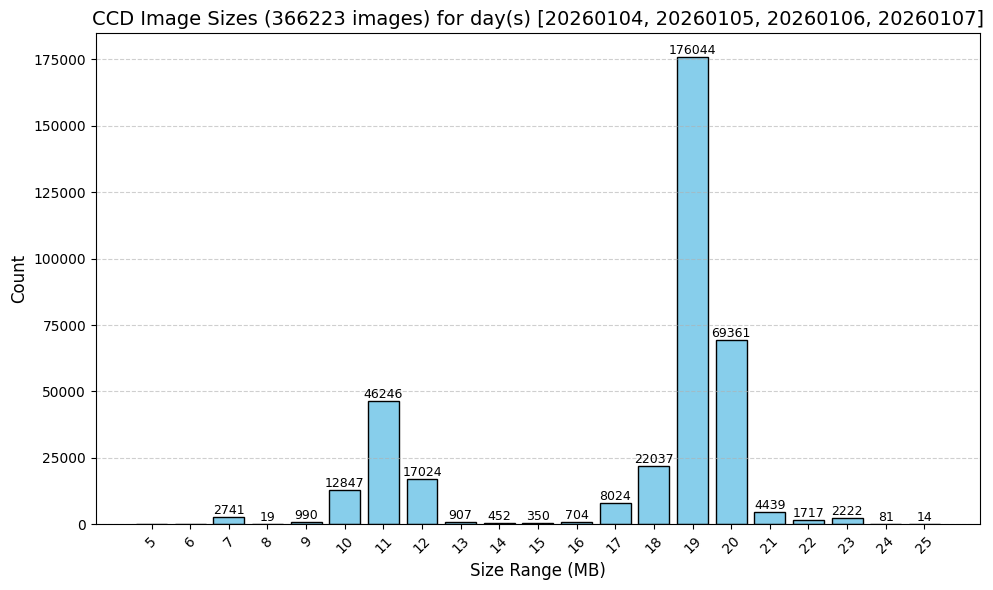

In [54]:
import numpy as np
import matplotlib.pyplot as plt


bins =  list(range(5, 27))
# Compute histogram
hist, edges = np.histogram(sizes, bins=bins)

# Create bin labels int
bin_labels = [f"{int(edges[i])}" for i in range(len(edges)-1)]
# Plot histogram
plt.figure(figsize=(10, 6))
bars = plt.bar(bin_labels, hist, width=0.8, edgecolor='black', color='skyblue')
for bar in bars:
    height = bar.get_height()
    if height > 0:
        plt.text(bar.get_x() + bar.get_width() / 2, height + 0.5, str(height),
                 ha='center', va='bottom', fontsize=9)

# Labels and title
plt.xlabel("Size Range (MB)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title(f"CCD Image Sizes ({len(sizes)} images) for day(s) {days}", fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [55]:
from sklearn.mixture import GaussianMixture

# Reshape for sklearn
X = sizes.reshape(-1, 1)

# Fit GMM with 2 components
gmm = GaussianMixture(n_components=2, random_state=0)
gmm.fit(X)

# Extract means
means = gmm.means_.flatten()
# Sort for readability
means = np.sort(means)

print("Estimated means for CCD image size:", means)

Estimated means: [11.56012075 19.70186576]
